In [ ]:
library(ggplot2)
library(dplyr)

In [2]:
library(ROCR)

In [ ]:
getwd()

In [3]:
lasso_prs <- read.table('/staging/leuven/stg_00092/IBP_PRSproject/lassoSumOutput/pgs_results.txt')

In [4]:
head(lasso_prs)
lasso_prs <- na.omit(lasso_prs)

,FID,IID,pheno,order,best.pgs
,<int>,<int>,<int>,<int>,<dbl>
1,9263,9263,1,1,-0.001322024
2,9535,9535,2,2,0.003012930
3,5924,5924,2,3,0.005271472
4,2762,2762,2,4,-0.002372954
5,9323,9323,1,5,0.000640863
6,7670,7670,2,6,-0.002104339


In [5]:
nrow(lasso_prs[(is.na(lasso_prs$pheno)),])

[1] 0

In [6]:
controls <- lasso_prs %>% filter(pheno == 1)
cases <- lasso_prs %>% filter(pheno == 2)

In [7]:
mean_cases <- mean(na.omit(cases$best.pgs)) 
iqr_cases <- IQR(na.omit(cases$best.pgs))

mean_controls <- mean(na.omit(controls$best.pgs))
iqr_controls <- IQR(na.omit(controls$best.pgs))

In [8]:
ybot <- ifelse(mean_controls - (iqr_controls * 1.5) < mean_cases - (iqr_cases * 1.5), iqr_controls*1.5, iqr_cases*1.5)
ytop <- ifelse(mean_controls + (iqr_controls * 1.5) > mean_cases + (iqr_cases * 1.5), iqr_controls*1.5, iqr_cases*1.5)

In [9]:
lasso_prs$pheno <- as.factor(lasso_prs$pheno)
#study_area.map[!(is.na(study_area.map[$brazil_loss_new2)),],

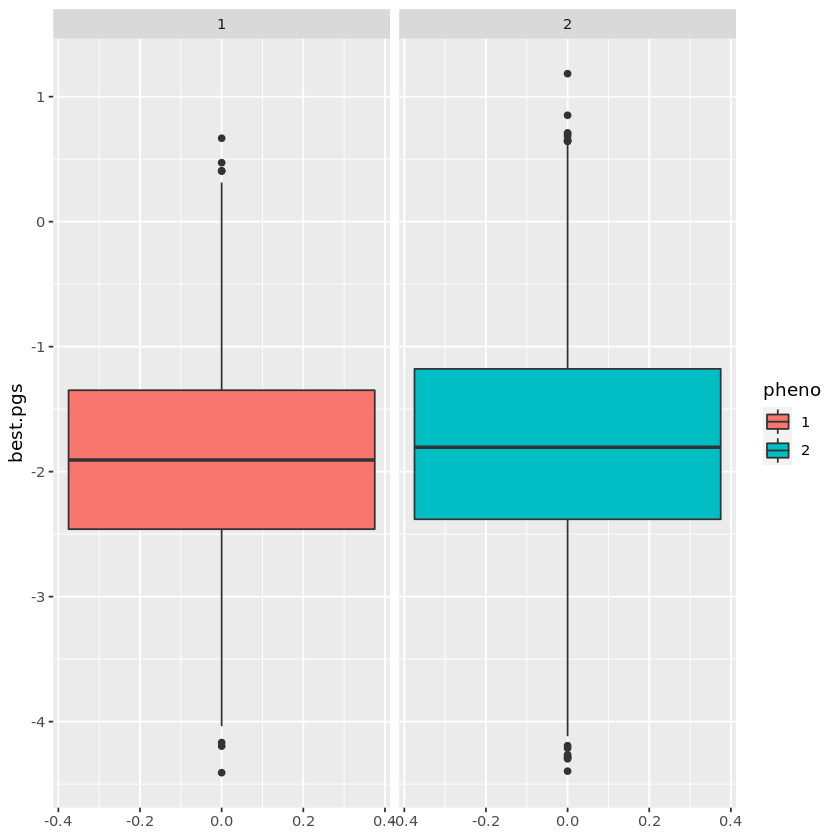

In [48]:
ggplot(lasso_stand[!(is.na(lasso_prs$pheno)),], aes(y = best.pgs, group = pheno, fill = pheno)) +
geom_boxplot() +  facet_wrap(~pheno)

Make ROCR plot

In [34]:
prs.1kg <- read.table('/staging/leuven/stg_00092/IBP_PRSproject/lassoSumOutput/pgs_results.1kg.txt')
head(prs.1kg)

,x
,<dbl>
1,0.0063249948
2,0.0024693989
3,0.0006242341
4,0.0078149951
5,0.0044017775
6,0.0031159597


In [38]:
#standrdize
prs.mean <- mean(prs.1kg$x)
prs.sd <- sd(prs.1kg$x)
lasso_stand <- lasso_prs %>% mutate(best.pgs = (best.pgs - prs.mean)/prs.sd)

In [39]:
head(lasso_stand)

,FID,IID,pheno,order,best.pgs
,<int>,<int>,<fct>,<int>,<dbl>
1,9263,9263,1,1,-2.1872717
2,9535,9535,2,2,-0.8988935
3,5924,5924,2,3,-0.2276393
4,2762,2762,2,4,-2.4996152
5,9323,9323,1,5,-1.6038881
6,7670,7670,2,6,-2.4197808


In [40]:
df_case <- lasso_stand %>% filter(pheno == 2)
df_control <- lasso_stand %>% filter(pheno == 1)

index_case = sample(1:nrow(df_case), size = .80 * nrow(df_case))
index_control = sample(1:nrow(df_control), size = 0.80 * nrow(df_control))

train_control <- df_control[index_control,]
train_case <- df_case[index_case,]

test_control <- df_control[-index_control,]
test_case <- df_case[-index_case, ]

#merge the test and train sets and remove nas
train_mrg <- rbind(train_case, train_control) %>% na.omit()
test_mrg <- rbind(test_case, test_control) %>% na.omit()



In [41]:
nrow(train_mrg)

[1] 3091

In [42]:
head(test_mrg)

,FID,IID,pheno,order,best.pgs
,<int>,<int>,<fct>,<int>,<dbl>
3,5924,5924,2,3,-0.2276393
10,2706,2706,2,10,-2.5732039
12,9532,9532,2,12,-2.6102171
14,2058,2058,2,14,-1.6527017
20,5493,5493,2,19,-2.1137243
21,7810,7810,2,20,-1.2223417


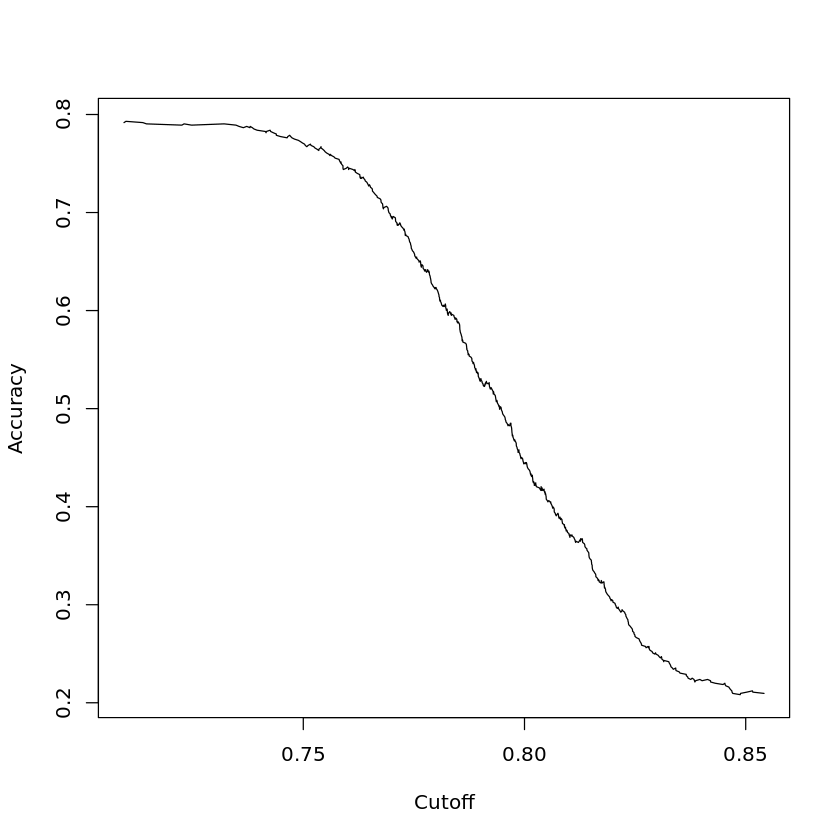

In [43]:
#generate model for training
log_model <- glm(pheno ~ best.pgs, data = train_mrg, family = binomial(link = "logit"))
#determine the prediction for test
log_pred <- predict(log_model, test_mrg, type = 'response')

#
log_pred <- prediction(log_pred, test_mrg$pheno)
perf <- performance(log_pred, "acc")
plot(perf)


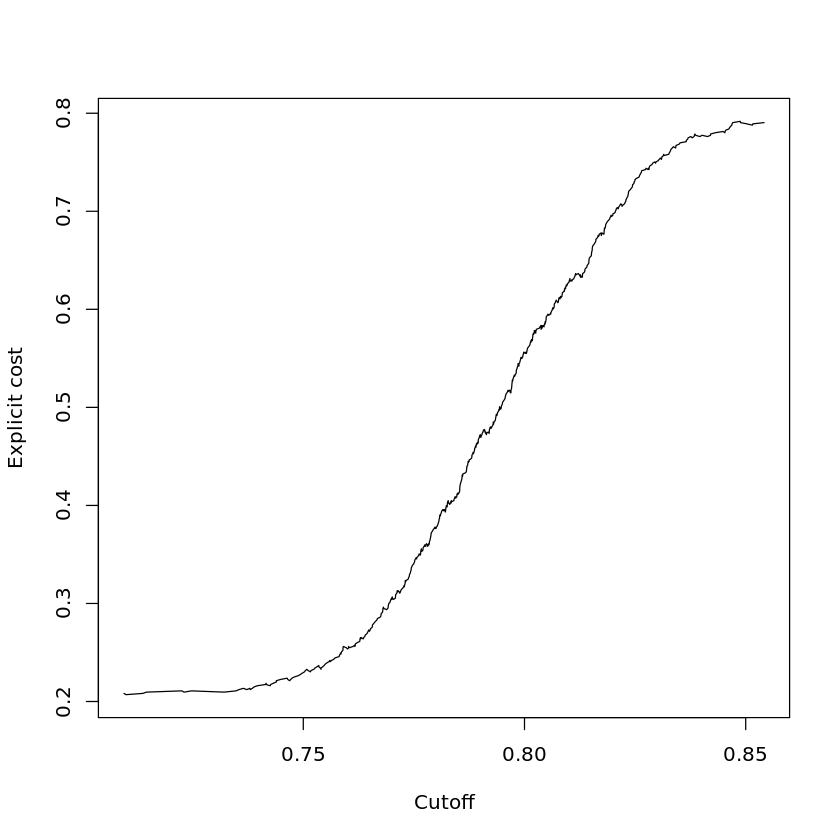

In [44]:

perf_cost <- performance(log_pred, "cost")
perf_err <- performance(log_pred, "err")
perf_tpr <- performance(log_pred, "tpr")
perf_sn_sp <- performance(log_pred, "sens", "spec")

plot(perf_cost)


   accuracy cutoff.1470 
  0.7930142   0.7099167 


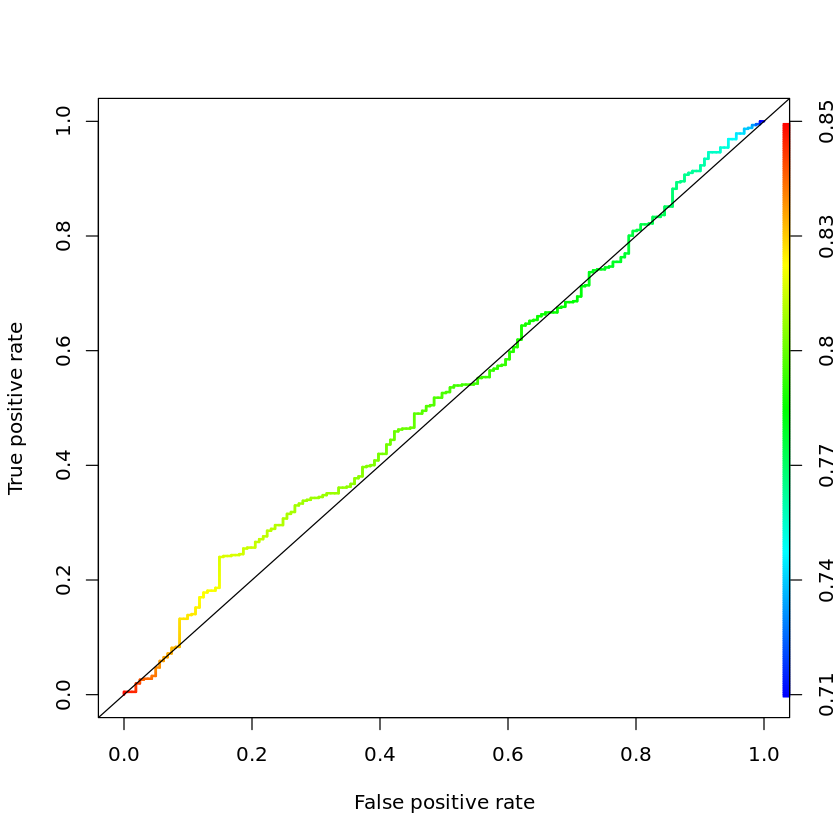

In [45]:

max_ind = which.max(slot(perf, "y.values")[[1]] )
acc = slot(perf, "y.values")[[1]][max_ind]
cutoff = slot(perf, "x.values")[[1]][max_ind]
print(c(accuracy= acc, cutoff = cutoff))


roc = performance(log_pred,"tpr","fpr")
plot(roc, colorize = T, lwd = 2)
abline(a = 0, b = 1) 

In [47]:
#AUC
auc = performance(log_pred, measure = "auc")
print(auc@y.values)

[[1]]
[1] 0.5182377

